# *Data-generating notebook*

In [58]:
%matplotlib inline

In [59]:
import os
import sys
sys.path.append('../code')
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from LatEvModels import LocallyLinearEvolution
from ObservationModels import PoissonObs

DTYPE = tf.float32

### The `generate_fake_data` function - defined below - calls the Evolution and Observation models. These accept some parameters, that should be passed to `generate_fake_data` as attributes of an instance of the class `Params`. (this hassle is for compatibility with `tensorflow`'s flags).

### Importantly, the `xDim` and `yDim` parameters set the dimensions of the latent space and generated data respectively

In [60]:
class Params():
    """
    """
    def __init__(self):
        self.xDim = 2
        self.yDim = 20
        
        self.initrange_MuX = 0.2
        self.initrange_B = 3.0
        self.init_Q0 = 1.0
        self.init_Q = 1.0
        self.alpha = 0.5
        self.initrange_outY = 3.0
params = Params()

### This function generates the data and provides some visualization at your convenience

In [61]:
def generate_fake_data(lat_mod_class, gen_mod_class, params,
                       data_path=None,
                       save_data_file=None,
                       Nsamps=100,
                       NTbins=30,
                       write_params_file=False,
                       draw_quiver=False,
                       draw_heat_maps=True,
                       savefigs=False):
    """
    Generate synthetic data by defining a model of latent evolution, an observation model, 
    and subsequently drawing samples from them. Optionally, it pickles the data for later 
    use. Maybe you would like to train a model? ;)
    
    Args:
        params: Object whose attributes are the hyperparameters of the evolution and
                observation models. These include in particular `xDim` and `yDim`: the
                dimensions of the latent space and observations 
        lat_mod_class: A string that is a key to the evolution model class. Currently 
                    'llinear' -> `LocallyLinearEvolution` is implemented.
        gen_mod_class: A string that is a key to the observation model class. Currently
                    'Poisson' -> `PoissonObs` is implemented
        data_path: The local directory where the generated data should be stored. If None,
                    don't store shit.
        save_data_file: The name of the file to hold your data
        Nsamps: Number of trials to generate
        NTbins: Number of time steps to run.
        write_params_file: Would you like the parameters with which this data has been 
                    generated to be saved to a separate txt file?
    
    Returns:
        Ydata, Xdata: Tuple of 3D tensors of generated synthetic data with shapes
                    [Nsamps, NTbins, dim] where dim is yDim/xDim.
    """    
    print('Generating some fake data...!\n')
    lat_mod_classes = {'llinear' : LocallyLinearEvolution}
    gen_mod_classes = {'Poisson' : PoissonObs}

    evolution_class = lat_mod_classes[lat_mod_class]
    generator_class = gen_mod_classes[gen_mod_class]

    if data_path:
        if not type(save_data_file) is str:
            raise ValueError("`save_data_file` must be string (representing the name of your file) "
                             "if you intend to save the data (`data_path` is not None)")
        if not os.path.exists(data_path): os.makedirs(data_path)
        if write_params_file:
            write_option_file(data_path)
    
    # Generate data
    tf.reset_default_graph()
    graph = tf.Graph()
    with graph.as_default():
        with tf.Session() as sess:
            xDim = params.xDim
            yDim = params.yDim
            if not Nsamps: Nsamps = params.genNsamps
            if not NTbins: NTbins = params.genNTbins

            # Define the models
            X = tf.placeholder(DTYPE, shape=[None, None, xDim], name='X')
            Y = tf.placeholder(DTYPE, shape=[None, None, yDim], name='Y')
            latm = evolution_class(X, params)
            genm = generator_class(Y, X, params, latm, is_out_positive=True)
            
            # Divide the data in train, validation and test
            Nsamps_train = int(4*Nsamps/5)
            valid_test = int(Nsamps/10)
            sess.run(tf.global_variables_initializer())
            Ydata, Xdata = genm.sample_XY(sess, 'X:0', Nsamps=Nsamps, NTbins=NTbins, with_inflow=True)
            Ytrain, Xtrain = Ydata[:Nsamps_train], Xdata[:Nsamps_train]
            Yvalid, Xvalid = Ydata[Nsamps_train:valid_test], Xdata[Nsamps_train:valid_test]
            Ytest, Xtest = Ydata[valid_test:], Xdata[valid_test:]

            # If xDim == 2, draw a cool path plot
            if draw_quiver and xDim == 2:
                latm.plot_2Dquiver_paths(sess, Xdata, 'X:0', rlt_dir=data_path,
                                     with_inflow=True, savefig=savefigs)
            if draw_heat_maps:
                print("Let's take a look at a couple heat maps of the actual data now")
                maxY = np.max(Ydata)
                fig, axes = plt.subplots(1,3, figsize=(18,4))
                for i in range(3):
                    sns.heatmap(Ydata[i].T, yticklabels=False, vmax=maxY, ax=axes[i]).get_figure()
                    if savefigs:
                        plt.savefig(data_path + "heat" + str(i) + ".png")
                plt.show()
                plt.close()
            
    if data_path:
        datadict = {'Ytrain' : Ytrain, 'Yvalid' : Yvalid, 'Xtrain' : Xtrain, 'Xvalid' : Xvalid,
                    'Ytest' : Ytest, 'Xtest' : Xtest}
        with open(data_path + save_data_file, 'wb+') as data_file:
            pickle.dump(datadict, data_file)
    
        if params.save_to_vind: # for old Python 2 code. Not guaranteed to work.
            with open(data_path + save_data_file + '_vind', 'wb+') as data_file:
                pickle.dump(datadict, data_file, protocol=2)
            
    return Ydata, Xdata

### Generate the data then

Generating some fake data...!

Sampling from latent dynamics...
rate 2 (mean, std, max) 1.80681 2.06695 9.7999
Ydata 2 (mean, std, max) 1.81351666667 2.47740602911 18
Hola
savefig False


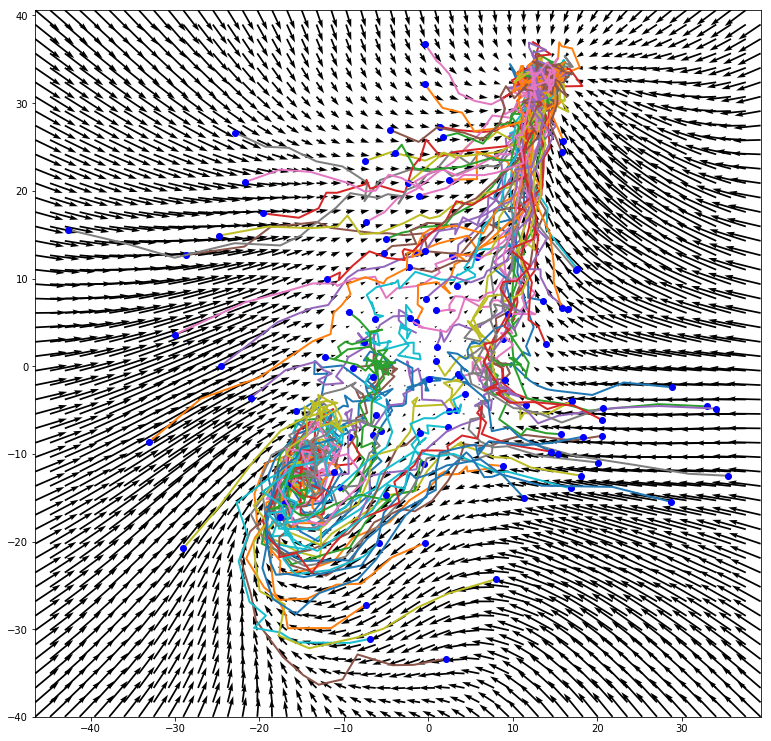

Press Enter to continue.
Let's take a look at a couple heat maps of the actual data now


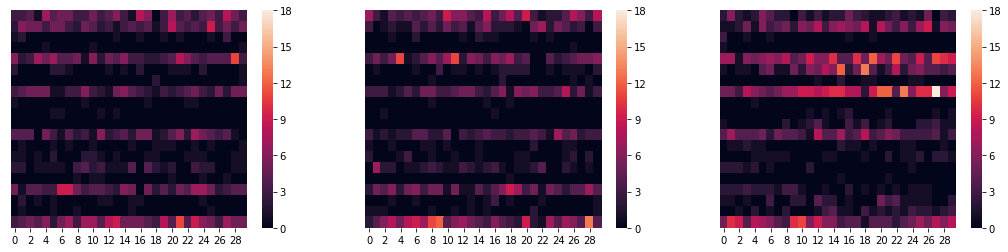

In [62]:
Ydata, Xdata = generate_fake_data(lat_mod_class='llinear',
                           gen_mod_class='Poisson', params=params,
                           data_path=None,
                           save_data_file=None,
                           write_params_file=False,
                           draw_quiver=True,
                           draw_heat_maps=True,
                           savefigs=False)

In the above, the *x*-axis represents time, the *y*-axis are the number of neurons in the data (dimensions). The plots show the activity of said neurons.